In [31]:
import pandas as pd
import numpy as  np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import jaro
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
tokenizer = RegexpTokenizer(r'\w+')


In [3]:
df = pd.read_csv("listings_train_reg.csv")
df = df.replace({np.nan: None})


test_df = pd.read_csv("listings_test_promoted_without_label.csv")

df = df.drop(df.columns[0], axis=1)
df.drop(columns = ["context"], inplace = True)
test_df.drop(columns = ["context"], inplace = True)


len(df), len(test_df)

(47806, 3699)

In [55]:
df.columns

Index(['listing_id', 'gig_id', 'position', 'created_at', 'is_click',
       'operating_system', 'is_filtered', 'gig_price', 'gig_avg_rating',
       'gig_rated_orders', 'imp_badge', 'is_seller_onlie', 'search_query',
       'is_user_buyer', 'gig_sc_id', 'gig_title',
       'cnt_helpful_reviews_last_year', 'avg_review_length_last_3_months',
       'avg_position_shown_last_60d', 'user_timezone', 'user_reg_date',
       'previous_order_sc_id', 'previous_order_amount', 'previous_order_date',
       'days_since_previous_order_date', 'hour', 'weekday', 'month',
       'has_title', 'user_reg_date_month', 'user_reg_date_year',
       'days_since_reg', 'title_length', 'number_of_words_in_title',
       'gig_title_length', 'gig_title_num_of_words', 'search_query_lwngth',
       'search_query_num_of_words', 'search_query_words', 'gig_title_words',
       'jaccard_similarity_title_query', 'jaro_distance'],
      dtype='object')

In [5]:
df[["created_at", "previous_order_date", "user_reg_date"]].sample(1)

,created_at,previous_order_date,user_reg_date
19668,2023-10-28 04:13:54.049,2023-10-20 05:44:56.268,2023-10-16 15:05:36.447000


In [95]:
def clean(df):
    
    df['gig_avg_rating'] = df['gig_avg_rating'].replace(np.nan, -1)
    df['gig_rated_orders'] = df['gig_rated_orders'].replace(np.nan, -1)
    df['gig_sc_id'] = df['gig_sc_id'].replace(np.nan, -1)
    df['cnt_helpful_reviews_last_year'] = df['cnt_helpful_reviews_last_year'].replace(np.nan, -1)
    df['avg_review_length_last_3_months'] = df['avg_review_length_last_3_months'].replace(np.nan, -1)
    df['avg_position_shown_last_60d'] = df['avg_position_shown_last_60d'].replace(np.nan, -1)
    df['user_timezone'] = df['user_timezone'].replace(np.nan, "UNK")
    df['previous_order_sc_id'] = df['previous_order_sc_id'].replace(np.nan, -1)
    df['previous_order_amount'] = df['previous_order_amount'].replace(np.nan, -1)
    df['gig_price'] = df['gig_price'].replace(np.nan, -1)

    return df


In [ ]:
df = clean(df)

In [7]:
def train_vectoriser(df, column, tokenizer, max_df =0.9, min_df = 0.005, lowercase = True, stop_words = "english"):

    vectorizer = TfidfVectorizer(max_df =0.9, min_df = 0.005, tokenizer =  tokenizer.tokenize,
                                  lowercase = True, stop_words = "english")
    vectorizer.fit(df[df[column].notnull()][column].tolist())
    
    query_vectorizer = TfidfVectorizer(max_df =0.9, min_df = 0.005,  tokenizer =  tokenizer.tokenize, lowercase = True, stop_words = "english")
    query_vectorizer.fit(df[df["search_query"].notnull()]["search_query"].tolist())


    return vectorizer


def jaccard_similarity(str1, str2):
    set1 = set(tokenizer.tokenize(str1)) if str1 is not None else set()
    set2 = set(tokenizer.tokenize(str2)) if str2 is not None else set()

    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
     
    return intersection / union




In [8]:
df[df["created_at"].isnull()]

,listing_id,gig_id,position,created_at,is_click,operating_system,is_filtered,gig_price,gig_avg_rating,gig_rated_orders,...,gig_sc_id,gig_title,cnt_helpful_reviews_last_year,avg_review_length_last_3_months,avg_position_shown_last_60d,user_timezone,user_reg_date,previous_order_sc_id,previous_order_amount,previous_order_date


In [9]:
def enrich(df):

    df["created_at"] = pd.to_datetime(df["created_at"])
    df["previous_order_date"] = pd.to_datetime(df["previous_order_date"])
    df["user_reg_date"] = pd.to_datetime(df["user_reg_date"])

    df = df.replace({np.nan: None})

    
    
    df["is_filtered"] = df["is_filtered"].astype(bool)
    df["is_user_buyer"] = df["is_user_buyer"].astype(bool)
    
    df["days_since_previous_order_date"] = df.apply(lambda r: (r["created_at"] - r["previous_order_date"]).days if r["previous_order_date"] is not None else -1, axis=1)
    df["hour"] = df["created_at"].apply(lambda date: date.hour)
    df["weekday"] = df["created_at"].apply(lambda date: date.weekday())
    df["month"] = df["created_at"].apply(lambda date: date.month)
    df["has_title"] = df["gig_title"].notnull()
    df["user_reg_date_month"] = df["user_reg_date"].apply(lambda date: date.month if date is not None else -1)
    df["user_reg_date_year"] = df["user_reg_date"].apply(lambda date: date.year if date is not None else -1)
    
    
    df["days_since_reg"] = df.apply(lambda r: (r["created_at"] - r["user_reg_date"]).days if r["user_reg_date"] is not None else -1, axis=1)
    
    
    
    
    df["title_length"] =  df["gig_title"].apply(lambda t: len(t) if t is not None else 0)
    df["number_of_words_in_title"] =  df["gig_title"].apply(lambda t: len(t.split(" ")) if t is not None else 0)

    df["gig_title_length"] = df["gig_title"].apply(lambda x: len(x) if x is not None else -1)

    df["gig_title_num_of_words"] = df["gig_title"].apply(lambda x: len(tokenizer.tokenize(x)) if x is not None else -1)
    
    df["search_query_lwngth"] = df["search_query"].apply(lambda x: len(x) if x is not None else -1)
    
    df["search_query_num_of_words"] = df["search_query"].apply(lambda x: len(tokenizer.tokenize(x)) if x is not None else -1)
    
    

    df["search_query_words"] = df["search_query"].str.lower().apply(tokenizer.tokenize)
    df["gig_title_words"] = df["gig_title"].str.lower().apply(lambda x: tokenizer.tokenize(x) if x is not None else [])
    
    
    
    df["jaccard_similarity_title_query"] = df.apply(lambda r: jaccard_similarity(r["search_query"], r["gig_title"])  ,axis=1)
    
    
    df["jaro_distance"] = df.apply(lambda r: jaro.jaro_winkler_metric(r["search_query"], r["gig_title"]) if r["gig_title"] is not None else -1, axis=1)
    


    return df 


In [10]:
df = enrich(df)

In [13]:
# rr = df[df["days_since_previous_order_date"].isnull()][["listing_id", "days_since_previous_order_date", "created_at", "previous_order_date"]]
# r = rr.iloc[0]

# r["previous_order_date"]

In [8]:

# for i in range(len(df)):
    
#     r = df.iloc[i]


#     for col in df.columns:
#         if r[col] is None:
#             print(i, col, r[col])
    

In [12]:
features = ["position",
       'operating_system', 'is_filtered', 'gig_price', 'gig_avg_rating',
       'gig_rated_orders', 'imp_badge', 'is_seller_onlie',
       'is_user_buyer', 'gig_sc_id',
       'cnt_helpful_reviews_last_year', 'avg_review_length_last_3_months',
       'avg_position_shown_last_60d', 'user_timezone',
       'previous_order_sc_id', 'previous_order_amount',
       'days_since_previous_order_date', 'hour', 'weekday', 'month',
       'has_title', 'user_reg_date_month', 'user_reg_date_year',
       'title_length', 'number_of_words_in_title',
         "jaccard_similarity_title_query","jaro_distance",
           "gig_title_length", "gig_title_num_of_words", "search_query_lwngth", 
            "search_query_num_of_words",
            "search_query", "gig_title" ,
            "days_since_reg"
           ]

y = "is_click"
features

['position',
 'operating_system',
 'is_filtered',
 'gig_price',
 'gig_avg_rating',
 'gig_rated_orders',
 'imp_badge',
 'is_seller_onlie',
 'is_user_buyer',
 'gig_sc_id',
 'cnt_helpful_reviews_last_year',
 'avg_review_length_last_3_months',
 'avg_position_shown_last_60d',
 'user_timezone',
 'previous_order_sc_id',
 'previous_order_amount',
 'days_since_previous_order_date',
 'hour',
 'weekday',
 'month',
 'has_title',
 'user_reg_date_month',
 'user_reg_date_year',
 'title_length',
 'number_of_words_in_title',
 'jaccard_similarity_title_query',
 'jaro_distance',
 'gig_title_length',
 'gig_title_num_of_words',
 'search_query_lwngth',
 'search_query_num_of_words',
 'search_query',
 'gig_title',
 'days_since_reg']

In [13]:
def split_train_validation(df, train_percent = 0.9):

    listing_df = df.groupby(["listing_id"])["created_at"].min().reset_index().sort_values(by = ["created_at"])
    
    train_size = int(listing_df.shape[0] * train_percent)
    
    train_listings_df = listing_df.iloc[0: train_size]
    validation_listings_df = listing_df.iloc[train_size:]
    
    train_df = pd.merge(df, train_listings_df[["listing_id"]], on = ["listing_id"])
    validation_df = pd.merge(df, validation_listings_df[["listing_id"]], on = ["listing_id"])
    
    train_y =  train_df[y]
    train_df = train_df[features]
    
    validation_y =  validation_df[y]
    validation_df = validation_df[features]

    return train_df,  validation_df, train_y, validation_y





In [60]:
def create_encoder(df, column, handle_unknown = "infrequent_if_exist"):
    enc = OneHotEncoder(handle_unknown=handle_unknown)
    enc.fit(train_df[[column]])
    return enc

def transform(df, encoder, column):
    transformed = encoder.transform(df[column].to_numpy().reshape(-1, 1))

    encoded_df = pd.DataFrame(data = transformed.toarray(), columns=encoder.get_feature_names_out().tolist())

    return pd.concat([df.drop(columns = [column]), encoded_df], axis=1)



def run_tfidf(vectoriser, column, df):

    values = [val if val is not None else "" for val in df[column].tolist()]
    
    vectors = vectoriser.transform(values).toarray()
    encoded_df = pd.DataFrame(data = vectors, columns=vectoriser.get_feature_names_out().tolist())

    return pd.concat([df.drop(columns = [column]), encoded_df], axis=1)
    

def preprocessing(df, operating_system_encoder, imp_badge_encoder, user_timezone_encoder, 
                 title_vectoriser, query_vectoriser, gig_sc_id_encoder, previous_order_sc_id_encoder):

    df = transform(df, operating_system_encoder, "operating_system")
    df = transform(df, imp_badge_encoder, "imp_badge")
    df = transform(df, user_timezone_encoder, "user_timezone")

    df = transform(df, gig_sc_id_encoder, "gig_sc_id")
    df = transform(df, previous_order_sc_id_encoder, "previous_order_sc_id")
    

    df = run_tfidf(title_vectoriser, "gig_title", df)
    df = run_tfidf(query_vectoriser, "search_query", df)

    return df

In [61]:
train_df,  validation_df, train_y, validation_y = split_train_validation(df)

train_df.shape, validation_df.shape, train_y.shape, validation_y.shape,


((42960, 34), (4846, 34), (42960,), (4846,))

In [62]:
operating_system_encoder = create_encoder(train_df, "operating_system")
imp_badge_encoder = create_encoder(train_df, "imp_badge")
user_timezone_encoder = create_encoder(train_df, "user_timezone")

gig_sc_id_encoder = create_encoder(train_df, "gig_sc_id")
previous_order_sc_id_encoder = create_encoder(train_df, "previous_order_sc_id")

title_vectoriser = train_vectoriser(train_df, "gig_title", tokenizer)
query_vectoriser = train_vectoriser(train_df, "search_query", tokenizer)


In [63]:
train_df = preprocessing(train_df, operating_system_encoder, imp_badge_encoder, user_timezone_encoder, 
                 title_vectoriser, query_vectoriser, gig_sc_id_encoder, previous_order_sc_id_encoder)
validation_df = preprocessing(validation_df, operating_system_encoder, imp_badge_encoder, user_timezone_encoder, 
                 title_vectoriser, query_vectoriser, gig_sc_id_encoder, previous_order_sc_id_encoder)


In [65]:
scale_pos_weight = (len(train_y) - np.sum(train_y))/ np.sum(train_y)
scale_pos_weight

9.766917293233083

In [66]:
def train(n_estimators=100, max_depth=10, subsample = 0.8, 
                   colsample_bytree = 0.9, scale_pos_weight = 2):

    bst = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample = subsample, 
                   colsample_bytree = colsample_bytree, scale_pos_weight=scale_pos_weight)


    bst.fit(train_df.to_numpy(), train_y)

    return bst 



In [67]:
model = train(n_estimators=100, max_depth=10, subsample = 0.8,  colsample_bytree = 0.9, scale_pos_weight=scale_pos_weight)

In [69]:
def plot_roc(model, dataset_df, dataset_y, dataset_name):

    preds = model.predict_proba(dataset_df)[:, 1] 
    fpr, tpr, threshold = roc_curve(dataset_y, preds)
    roc_auc = auc(fpr, tpr)

    plt.title(f'{dataset_name} - ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

    

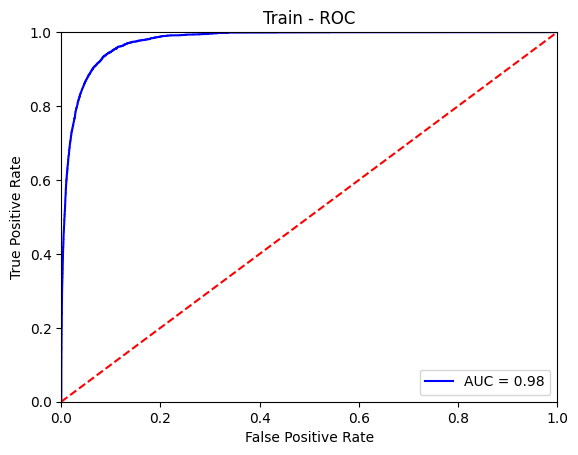

In [70]:
plot_roc(model, train_df.to_numpy(), train_y, "Train")


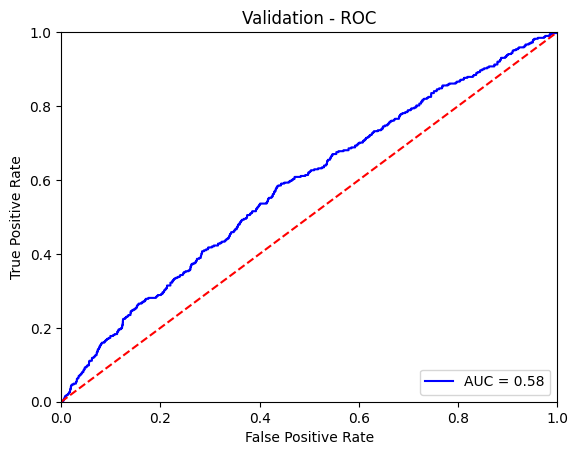

In [71]:
plot_roc(model, validation_df.to_numpy(), validation_y, "Validation")


In [72]:
lr = LogisticRegression( class_weight="balanced")

lr.fit(train_df.to_numpy(), train_y)


LogisticRegression(class_weight='balanced')

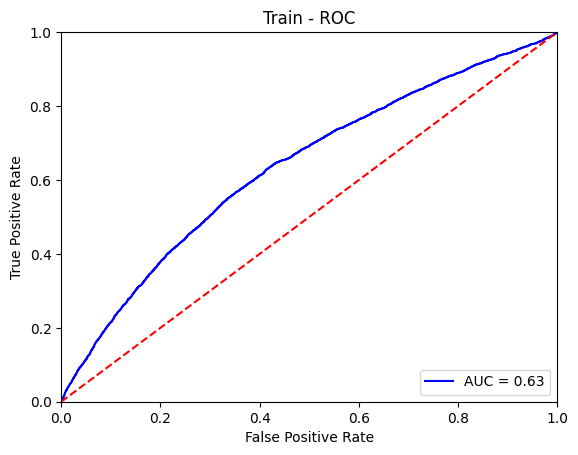

In [73]:
plot_roc(lr, train_df.to_numpy(), train_y, "Train")

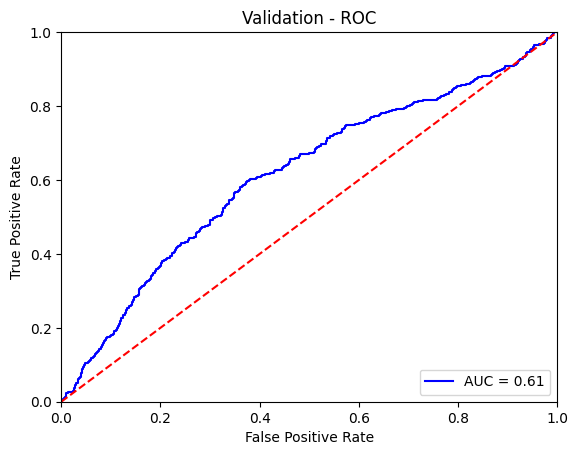

In [74]:
plot_roc(lr, validation_df.to_numpy(), validation_y, "Validation")

In [ ]:
def predict():
    

In [117]:
def predict_is_click(df, th = 0.6):
    
    df = clean(df)
    df = enrich(df)
    df = df[features]
    
    
    df = preprocessing(df, operating_system_encoder, imp_badge_encoder, user_timezone_encoder, 
                     title_vectoriser, query_vectoriser, gig_sc_id_encoder, previous_order_sc_id_encoder)
    
    
    
    #lr.predict(test_df.to_numpy())
    preds = lr.predict_proba(df)[:, 1] 
    
    return np.sum(np.where(preds > 0.6, 1, 0))




In [118]:
test_df = pd.read_csv("listings_test_promoted_without_label.csv")

test_df["prediction_is_click"] = predict_is_click(test_df)
test_df.to_csv("listings_test_promoted_without_label_with_prediction.csv", index = False)
